# Problem
* Choose any dataset for multiclass classification on [Kaggle](https://www.kaggle.com/) (go to "Datasets" section, choose "Filter" and enter "multiclass classification" into the "Tags" field). 
* Perform classification with few methods. I expect you to use at least SVM (linear and rbf) and random forest.
* Try getting the best result with each of the methods. I expect you to use at least GridSearch for hyperparameters tuning.
* Try feature engineering. I expect you to use at least PCA for dimensionality reduction.
* Calculate accuracy and confusion matrix for each of the methods.
* Draw conclusions. Which method is the best? Why? If the dataset has any articles linked, compare your results with the state of the art.

# Grading criteria:
* I expect a confident usage of sklearn methods.
* I expect understanding of basics of models assessment.
* I expect you to be able to learn PCA method on your own.
* I expect the ability of succinct, cohesive, and coherent expression of your thoughts, i.e. clearly state (in a few sentences) what is the problem you are solving, what approaches do you propose, and what conclusions can be drawn regarding these approaches in the context of the problem.

**About dataset** [[kaggle]](https://www.kaggle.com/datasets/zalando-research/fashionmnist)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

**State-of-Art** [[ref]](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)

The state-of-the-art models for the Fashion MNIST dataset typically involve advanced deep learning architectures, specifically convolutional neural networks (CNNs). Although Fashion MNIST is a relatively simple dataset compared to more challenging image datasets, several models have achieved exceptional performance. 

ResNet: The ResNet architecture, with its skip connections or residual connections, has shown strong performance on Fashion MNIST. Variants like ResNet-18, ResNet-34, and ResNet-50 can achieve high accuracy on the dataset.

*Shown accuracy: 96.41%*

In [40]:
# !pip install opendatasets
from IPython.display import Markdown as md
from IPython.display import display
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np, re
import scipy.stats as sts
import seaborn as sns
import os, opendatasets as od

# Downloading

In [41]:
class_names = {0:'T-shirt/top', 1:'Trouser',2: 'Pullover',3: 'Dress',4: 'Coat',5:
               'Sandal',6: 'Shirt', 7:'Sneaker',8:  'Bag',9: 'Ankle boot'}

if not os.path.exists('./fashionmnist'):
    od.download("https://www.kaggle.com/datasets/zalando-research/fashionmnist")
os.listdir('./fashionmnist')

['fashion-mnist_test.csv',
 'fashion-mnist_train.csv',
 't10k-images-idx3-ubyte',
 't10k-labels-idx1-ubyte',
 'train-images-idx3-ubyte',
 'train-labels-idx1-ubyte']

In [42]:
df_train, df_test = pd.read_csv('./fashionmnist/fashion-mnist_train.csv'), pd.read_csv('./fashionmnist/fashion-mnist_test.csv')
print(df_train.info(), df_test.info())
print(df_train.describe(), df_test.describe())
print(df_train.head(), df_test.head())
print('Memory usage of train:', df_train.memory_usage().sum() / 1024**2 )
print('Memory usage of test:', df_test.memory_usage().sum() / 1024**2 )
print(df_train.isnull().values.any())
print(df_test.isnull().values.any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB
None None
              label        pixel1        pixel2        pixel3        pixel4   
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000  \
mean       4.500000      0.000900      0.006150      0.035333      0.101933   
std        2.872305      0.094689      0.271011      1.222324      2.452871   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      0.000000      0.000000      0.000000      0.000000   
50%        4.500000      0.000000      0.000000      0.000000      0.000000   
75%        7.000000      0.000000      0.000000      0.000000      0.000000   
max        9.000000     16.000000     36.000

In [43]:
def reduce(df, verbose=None):
    print('Initial dataframe memory usage:', df.memory_usage().sum() / 1024**2)
    for col in df.columns:
        if verbose and verbose>=2:
            print(f'Column: {col}\nInitial dtype: {df[col].dtype}\n')
        
        df[col] = df[col].astype(np.float32) #.astype(np.uint8)
        
        if verbose and verbose>=1:
            print(f'Column: {col}\nNew dtype: {df[col].dtype}\n')
    print('New dataframe memory usage:', df.memory_usage().sum() / 1024**2)
    return df

In [44]:
df_train, df_test = reduce(df_train), reduce(df_test)

Initial dataframe memory usage: 359.3446044921875
New dataframe memory usage: 179.67236328125
Initial dataframe memory usage: 59.890869140625
New dataframe memory usage: 29.94549560546875


# Data exploration

In [45]:
from sklearn.model_selection import train_test_split
img_w, img_h = 28, 28
_xcol = ['pixel'+str(i+1) for i in range(28*28)]
_ycol = ['label']
_used = 0.3

x_train_full, y_train_full = df_train[_xcol].to_numpy(), df_train[_ycol].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x_train_full, y_train_full, test_size=2500, train_size=10000, random_state=42)
x_val, y_val = df_test[_xcol].to_numpy(), df_test[_ycol].to_numpy() 

print('Train:', x_train.shape, x_train.dtype, y_train.shape, y_train.dtype)
print('Test:', x_test.shape, y_test.shape)
print('Train classes:', np.unique(y_train))
print('Test classes:', np.unique(y_test))

Train: (10000, 784) float32 (10000, 1) float32
Test: (2500, 784) (2500, 1)
Train classes: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Test classes: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


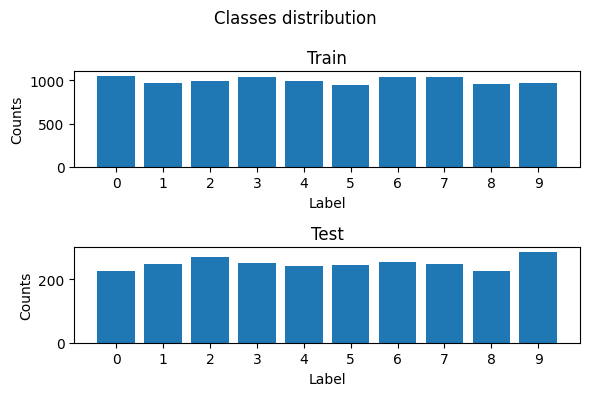

In [46]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (6,4))
names, counts = np.unique(y_train, return_counts=True)
ax[0].bar(names, counts)
ax[0].set_title('Train')
ax[0].set_xticks(names)
ax[0].set_ylabel('Counts')
ax[0].set_xlabel('Label')
names, counts = np.unique(y_test, return_counts=True)
ax[1].bar(names,counts)
ax[1].set_title('Test')
ax[1].set_xticks(names)
ax[1].set_ylabel('Counts')
ax[1].set_xlabel('Label')
fig.suptitle('Classes distribution')
plt.tight_layout()

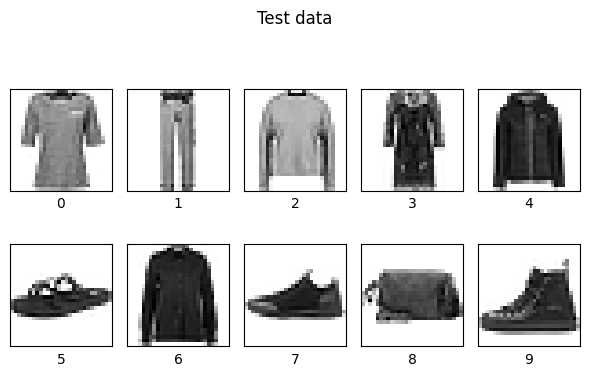

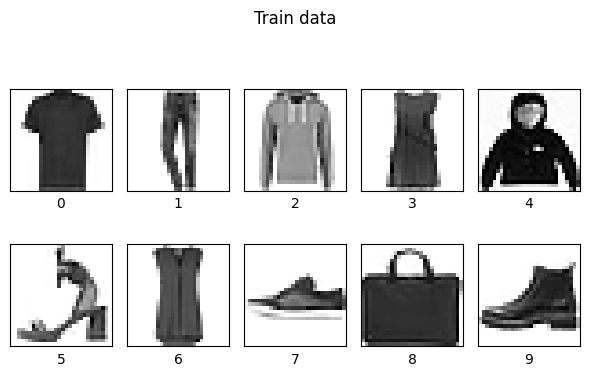

In [47]:
fig, ax = plt.subplots (nrows = 2, ncols = 5, figsize = (6,4))
ax = ax.flatten()
for i, iax in enumerate(ax):
    sample, label = x_train[y_train.flatten()==i][0], i
    iax.imshow(sample.reshape(img_h, img_w), cmap='binary')
    iax.set_xlabel(label)
    iax.set_xticks([])
    iax.set_yticks([])
fig.suptitle('Test data')
plt.tight_layout()

fig, ax = plt.subplots (nrows = 2, ncols = 5, figsize = (6,4))
ax = ax.flatten()
for i, iax in enumerate(ax):
    sample, label = x_test[y_test.flatten()==i][0], i
    iax.imshow(sample.reshape(img_h, img_w), cmap='binary')
    iax.set_xlabel(label)
    iax.set_xticks([])
    iax.set_yticks([])
fig.suptitle('Train data')
plt.tight_layout()

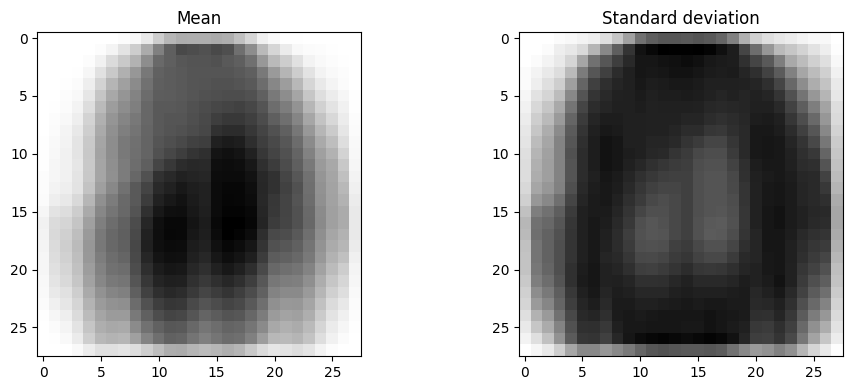

In [48]:
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].imshow(mean.astype(np.uint8).reshape(img_w,img_h), cmap='binary')
ax[1].imshow(std.astype(np.uint8).reshape(img_w,img_h), cmap='binary')
ax[0].set_title("Mean")
ax[1].set_title("Standard deviation")
plt.tight_layout()

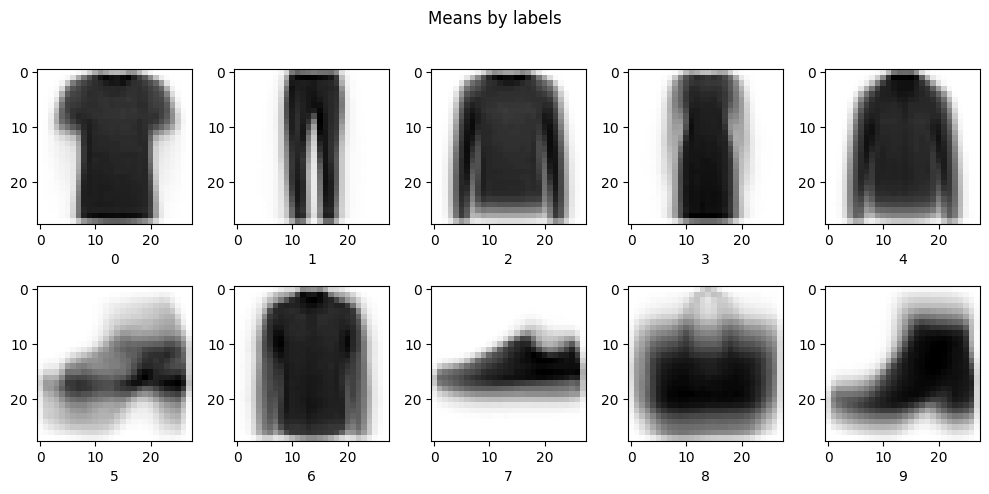

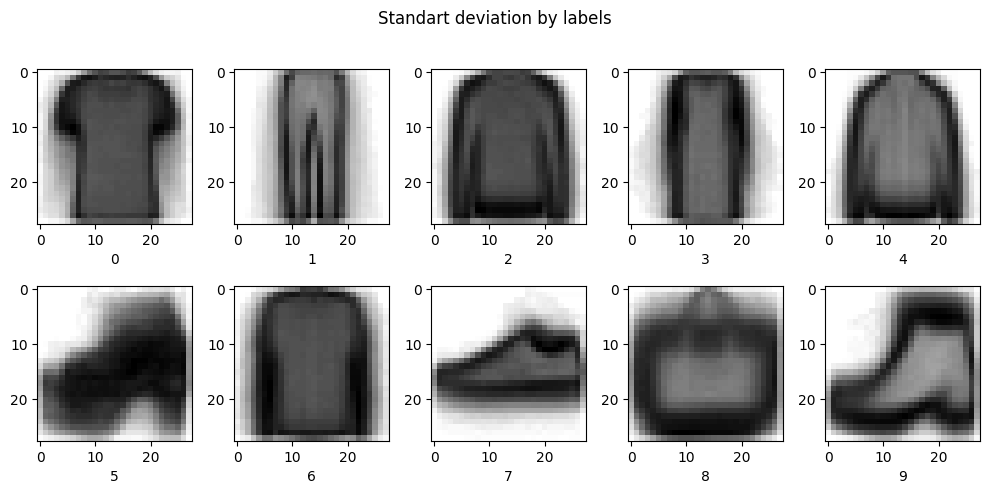

In [49]:
px_means=[]
px_stds=[]
for label in range(10):
    label_data = x_train[y_train.flatten()==label]
    mean = np.mean(label_data, axis=0)
    std = np.std(label_data, axis=0)
    px_means.append(mean)
    px_stds.append(std)
    
fig, ax = plt.subplots (nrows = 2, ncols = 5, figsize = (10,5))
ax = ax.flatten()
for i, iax in enumerate(ax):
    iax.imshow(px_means[i].astype(np.uint8).reshape(img_w,img_h), cmap='binary')
    iax.set_xlabel(i)
fig.suptitle('Means by labels')
plt.tight_layout()

fig, ax = plt.subplots (nrows = 2, ncols = 5, figsize = (10,5))
ax = ax.flatten()
for i, iax in enumerate(ax):
    iax.imshow(px_stds[i].astype(np.uint8).reshape(img_w,img_h), cmap='binary')
    iax.set_xlabel(i)
fig.suptitle('Standart deviation by labels')
plt.tight_layout()

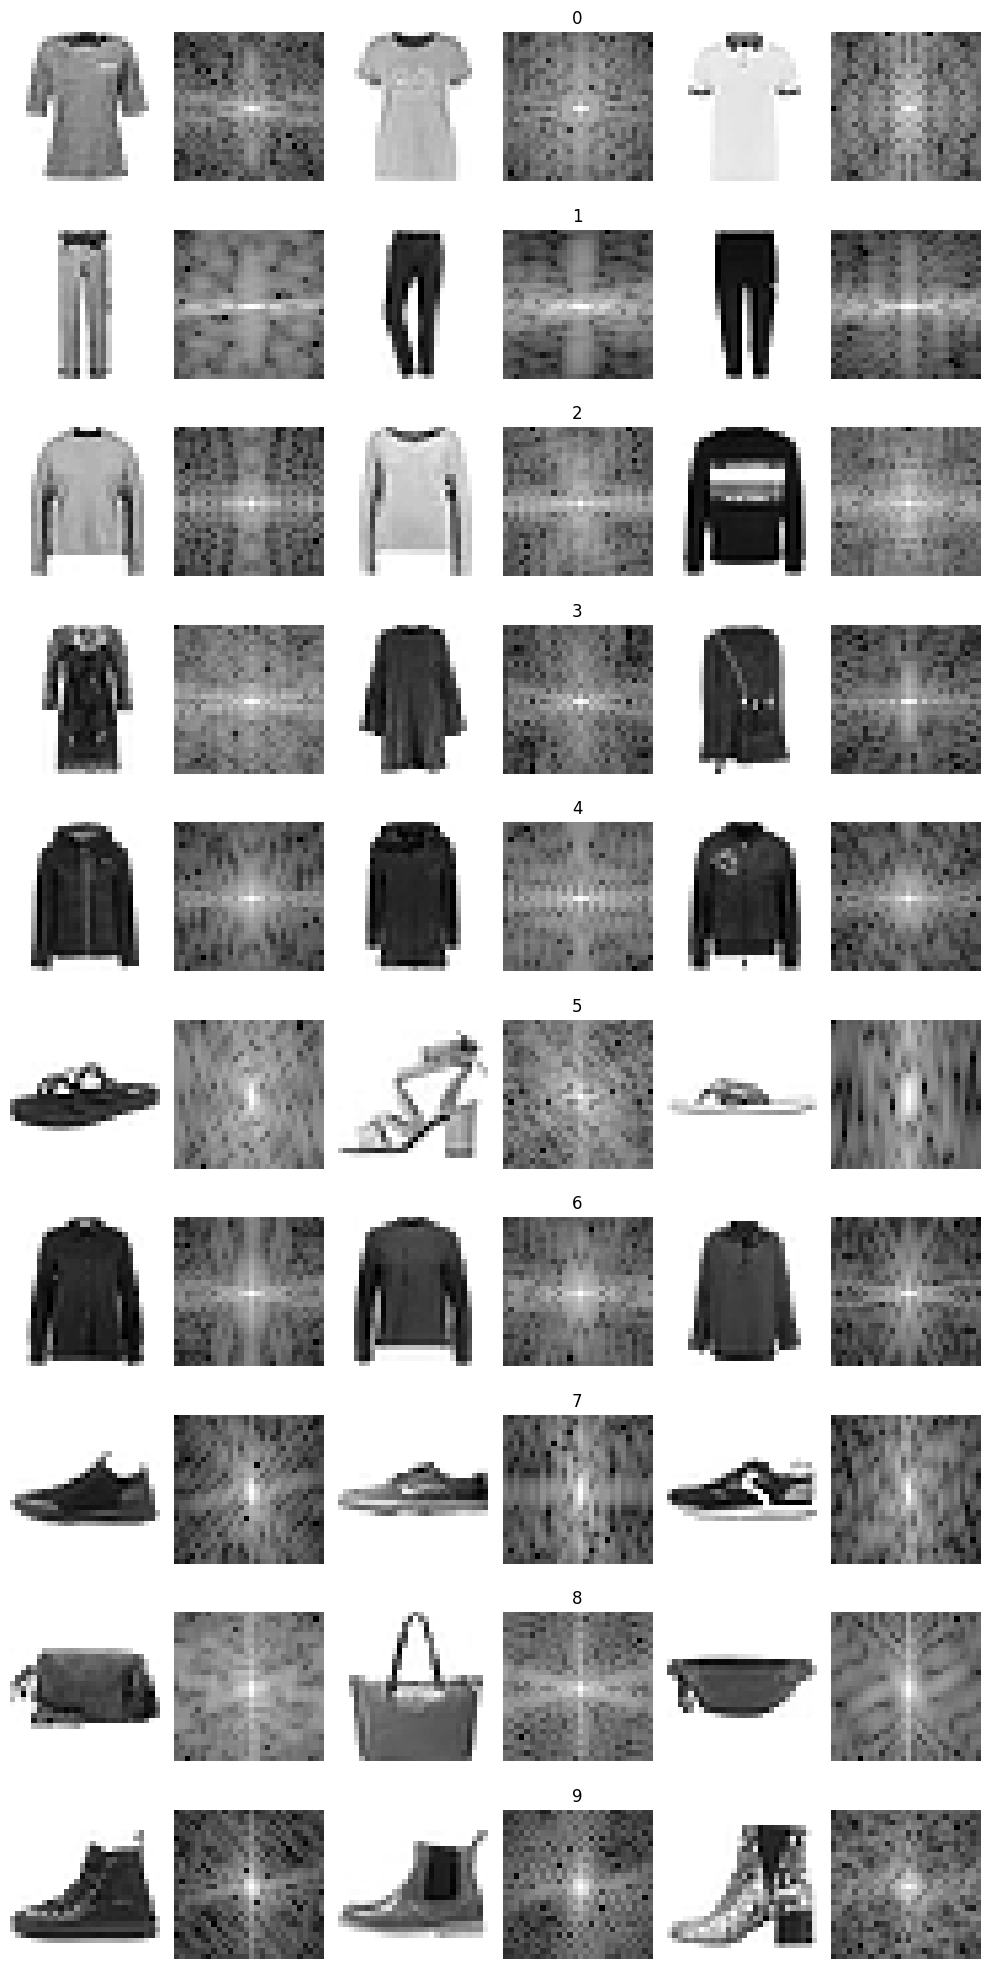

In [50]:
from scipy import fftpack
# Compute the two-dimensional Fourier transform of an image and visualize its power spectrum

num_examples = 3
fig, ax = plt.subplots(nrows=10, ncols=num_examples*2, figsize=(10, 20))

for iclass in range(10):
    img_idxs = np.where(y_train.flatten()==iclass)[0]

    for j,i in enumerate(img_idxs[:num_examples]):
        img_fft = fftpack.fft2(x_train[i].reshape(img_w, img_h))
        img_fft_shift = fftpack.fftshift(img_fft)
        power_spectrum = np.abs(img_fft_shift) ** 2

        ax[iclass][j*2].imshow(x_train[i].reshape(img_w, img_h), cmap='binary')
        ax[iclass][j*2+1].imshow(np.log10(power_spectrum), cmap='gray')
        ax[iclass][3].set_title(str(iclass))
        ax[iclass][j*2].axis('off')
        ax[iclass][j*2+1].axis('off')
plt.tight_layout()

# Feature engineering

(10000, 784)
(10000, 1)
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


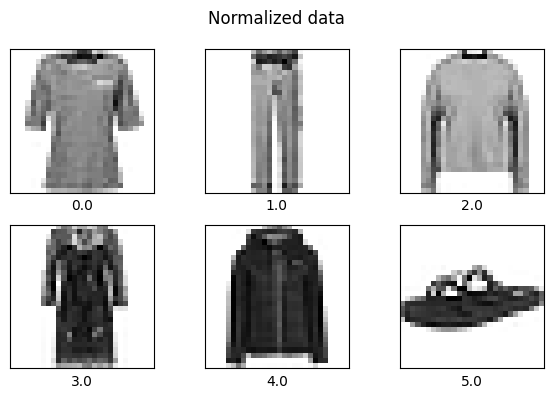

n_components for 0.85 118
n_components [275, 196, 118, 40]


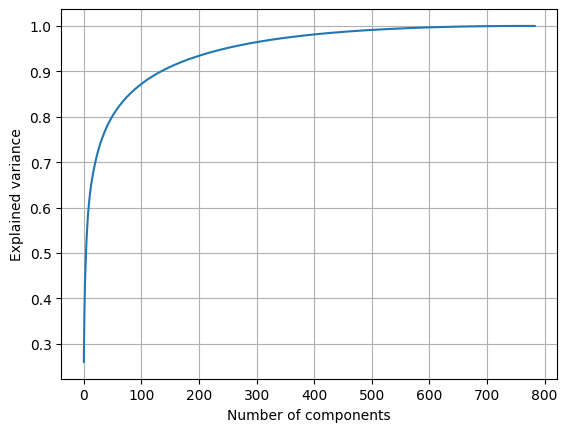

In [51]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x_pca_test = Normalizer().fit_transform(x_train)
print(x_pca_test.shape)
y_pca_test = y_train
print(y_pca_test.shape)
avaliable_cluster_labels = np.unique(y_pca_test)
print(avaliable_cluster_labels)

fig, ax = plt.subplots (nrows = 2, ncols = 3, figsize = (6,4))
ax = ax.flatten()
for i, iax in enumerate(ax):
    sample, label = x_pca_test[y_pca_test.flatten()==avaliable_cluster_labels[i]][0], avaliable_cluster_labels[i]
    iax.imshow(sample.reshape(img_h, img_w), cmap='binary')
    iax.set_xlabel(label)
    iax.set_xticks([])
    iax.set_yticks([])
fig.suptitle('Normalized data')
plt.tight_layout()
plt.show()

pca = PCA().fit(x_pca_test)
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

quantile = 0.85
n_components = np.where(pca.explained_variance_ratio_<np.quantile(pca.explained_variance_ratio_, quantile))[0].min()
print(f'n_components for {quantile}', n_components)

_test_n_components = [np.where(pca.explained_variance_ratio_<np.quantile(pca.explained_variance_ratio_, quantile))[0].min() 
                      for quantile in np.arange(0.65, 0.96, 0.1) ]

print(f'n_components', _test_n_components)

0.0 0.06262346
(1, 118) float32
Explained variance for n_components = 118: 0.88652694


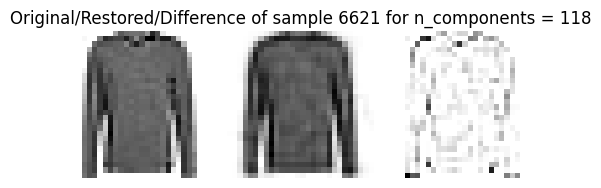

In [53]:
test_sample = np.random.randint(len(x_train))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(5,8))

pca= PCA(int(n_components)).fit(x_pca_test)
transformed_ = pca.transform(x_pca_test[test_sample].reshape(1,-1))
restored_ = pca.inverse_transform(transformed_)
restored_ = np.clip(restored_, 0, 1)
print(restored_.min(), restored_.max())
print(transformed_.shape, transformed_.dtype )
print(f'Explained variance for n_components = {n_components}:', np.sum(pca.explained_variance_ratio_))

ax[0].imshow(x_pca_test[test_sample].reshape(img_w, img_h), cmap='binary')
ax[0].axis('off')

ax[1].imshow(restored_.reshape(img_w, img_h), cmap='binary')
ax[1].axis('off')
ax[1].set_title(f'Original/Restored/Difference of sample {test_sample} for n_components = {n_components}')

ax[2].imshow(np.clip(x_pca_test[test_sample]-restored_, 0, 1).reshape(img_w, img_h), cmap='binary')
ax[2].axis('off')

plt.tight_layout()

In [14]:
del x_pca_test
n_components

118

# Classifiers

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report

results = dict()
_pipelines = dict()

def report(y_test, y_pred):
    #confussion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # metrics
    print('Report')
    report = classification_report(y_test, y_pred)
    print(report)
    accuracy = accuracy_score(y_test,y_pred)
    print('Accuracy', accuracy)

    sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.3g')
    plt.show()
    
    return accuracy

The **classification_report** function in scikit-learn provides a summary of evaluation metrics for a classification model.

+ **Precision** measures the model's accuracy in identifying positive instances correctly.
+ **Recall** measures the model's ability to find all positive instances.
+ The **F1-score** combines precision and recall into a single metric that balances their trade-off.
+ **Support** indicates the number of samples in each class.

## SVD

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
Report
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84       226
         1.0       0.99      0.94      0.96       249
         2.0       0.81      0.82      0.81       271
         3.0       0.83      0.93      0.87       252
         4.0       0.77      0.74      0.75       241
         5.0       0.93      0.93      0.93       246
         6.0       0.68      0.61      0.64       254
         7.0       0.92      0.92      0.92       249
         8.0       0.94      0.97      0.95       226
         9.0       0.95      0.94      0.95       286

    accuracy                           0.87      2500
   macro avg       0.86      0.87      0.86      2500
weighted avg       0.86      0.87      0.86      2500

Accuracy 0.866


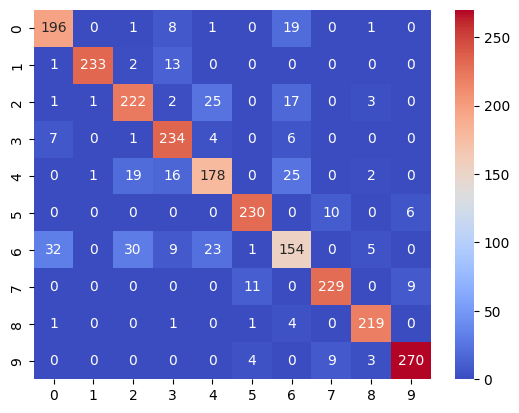

CPU times: total: 8.3 s
Wall time: 6.42 s


In [56]:
from sklearn.svm import SVC
from joblib import parallel_backend
%load_ext line_profiler

preprocessing_steps = [('normalizer', StandardScaler()), ('pca', PCA(n_components))]

def test():
    with parallel_backend('threading', n_jobs=4):
        estimator = ('svc_rbf', SVC(kernel='rbf'))
        model = Pipeline(steps=[*preprocessing_steps, estimator])
        model.fit(x_train, y_train.ravel()) 
        y_pred = model.predict(x_test)

    results['svc_rbf'] = [report(y_test.ravel(), y_pred)]
    _pipelines['svc_rbf'] = model
    
%time test()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
Report
              precision    recall  f1-score   support

         0.0       0.75      0.85      0.80       226
         1.0       0.96      0.94      0.95       249
         2.0       0.75      0.72      0.73       271
         3.0       0.85      0.87      0.86       252
         4.0       0.72      0.71      0.72       241
         5.0       0.94      0.95      0.94       246
         6.0       0.63      0.61      0.62       254
         7.0       0.93      0.93      0.93       249
         8.0       0.96      0.91      0.93       226
         9.0       0.95      0.94      0.95       286

    accuracy                           0.84      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.84      0.84      0.84      2500

Accuracy 0.8432


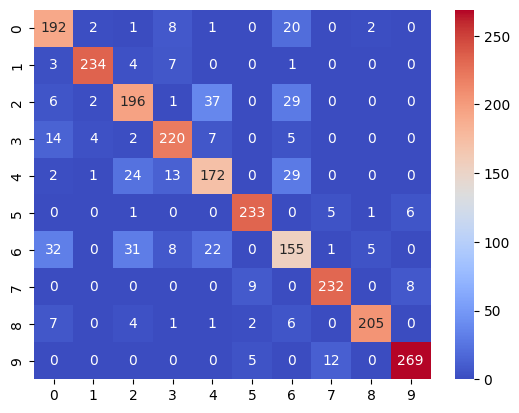

CPU times: total: 19.8 s
Wall time: 18.1 s


In [57]:
from sklearn.svm import SVC
from joblib import parallel_backend
%load_ext line_profiler

preprocessing_steps = [('normalizer', StandardScaler()), ('pca', PCA(n_components))]

def test():
    with parallel_backend('threading', n_jobs=4):
        estimator = ('linear', SVC(kernel='linear'))
        model = Pipeline(steps=[*preprocessing_steps, estimator])
        model.fit(x_train, y_train.ravel()) 
        y_pred = model.predict(x_test)

    results['svc_linear'] = [report(y_test.ravel(), y_pred)]
    _pipelines['svc_linear'] = model
    
%time test()

## Softmax Regression

D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Report
              precision    recall  f1-score   support

         0.0       0.80      0.85      0.82       226
         1.0       0.97      0.94      0.96       249
         2.0       0.77      0.71      0.74       271
         3.0       0.86      0.88      0.87       252
         4.0       0.71      0.71      0.71       241
         5.0       0.91      0.94      0.93       246
         6.0       0.60      0.61      0.61       254
         7.0       0.92      0.92      0.92       249
         8.0       0.96      0.93      0.95       226
         9.0       0.94      0.93      0.94       286

    accuracy                           0.84      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.84      0.84      0.84      2500

Accuracy 0.8428


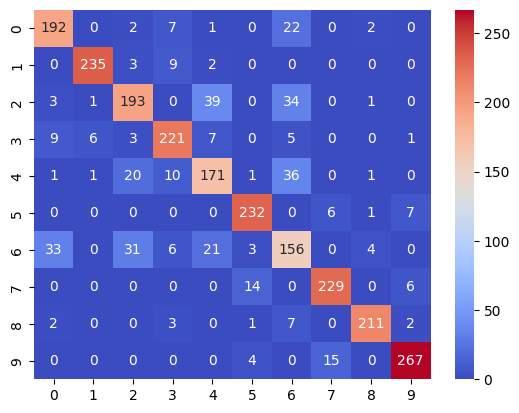

CPU times: total: 5.06 s
Wall time: 1.68 s


In [58]:
from sklearn.linear_model import LogisticRegression

preprocessing_steps = [('scaler', StandardScaler()), ('pca', PCA(n_components))]

def test():
    with parallel_backend('threading', n_jobs=4):
        estimator = ('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs'))
        model = Pipeline(steps=[*preprocessing_steps, estimator])
        model.fit(x_train, y_train.ravel()) 
        y_pred = model.predict(x_test)

    results['lr'] = [report(y_test.ravel(), y_pred)]
    _pipelines['lr'] = model
    
%time test()

## Random Forest

Report
              precision    recall  f1-score   support

         0.0       0.83      0.86      0.84       226
         1.0       0.99      0.94      0.96       249
         2.0       0.75      0.79      0.77       271
         3.0       0.83      0.92      0.87       252
         4.0       0.74      0.71      0.72       241
         5.0       0.92      0.91      0.91       246
         6.0       0.68      0.57      0.62       254
         7.0       0.90      0.89      0.90       249
         8.0       0.92      0.96      0.94       226
         9.0       0.92      0.94      0.93       286

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2500

Accuracy 0.848


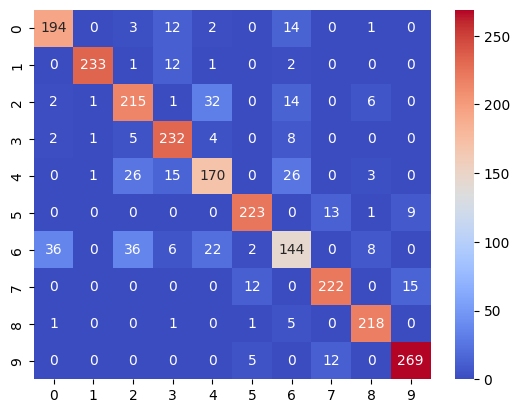

CPU times: total: 30.6 s
Wall time: 4.78 s


In [59]:
from sklearn.ensemble import RandomForestClassifier

preprocessing_steps = [('scaler', StandardScaler()), ('pca', PCA(n_components))]

def test():
    with parallel_backend('threading', n_jobs=4):
        estimator = ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
        model = Pipeline(steps=[*preprocessing_steps, estimator])
        model.fit(x_train, y_train.ravel()) 
        y_pred = model.predict(x_test)

    results['rf'] =[report(y_test.ravel(), y_pred)]
    _pipelines['rf'] = model
    
    
%time test()

## XGBoost Classifier

[0]	validation_0-mlogloss:2.27872
[1]	validation_0-mlogloss:2.28567
[2]	validation_0-mlogloss:2.28050
[3]	validation_0-mlogloss:2.28009
[4]	validation_0-mlogloss:2.28579
[5]	validation_0-mlogloss:2.28172
[6]	validation_0-mlogloss:2.27883
[7]	validation_0-mlogloss:2.27422
[8]	validation_0-mlogloss:2.27230
[9]	validation_0-mlogloss:2.27665
[10]	validation_0-mlogloss:2.27653
[11]	validation_0-mlogloss:2.27959
[12]	validation_0-mlogloss:2.28966
[13]	validation_0-mlogloss:2.29509
[14]	validation_0-mlogloss:2.28594
[15]	validation_0-mlogloss:2.29269
[16]	validation_0-mlogloss:2.28565
[17]	validation_0-mlogloss:2.28142
[18]	validation_0-mlogloss:2.27815
[19]	validation_0-mlogloss:2.27823
[20]	validation_0-mlogloss:2.27483
[21]	validation_0-mlogloss:2.27690
[22]	validation_0-mlogloss:2.27964
[23]	validation_0-mlogloss:2.27273
[24]	validation_0-mlogloss:2.27939
[25]	validation_0-mlogloss:2.27787
[26]	validation_0-mlogloss:2.28421
[27]	validation_0-mlogloss:2.28553
[28]	validation_0-mlogloss:2.2

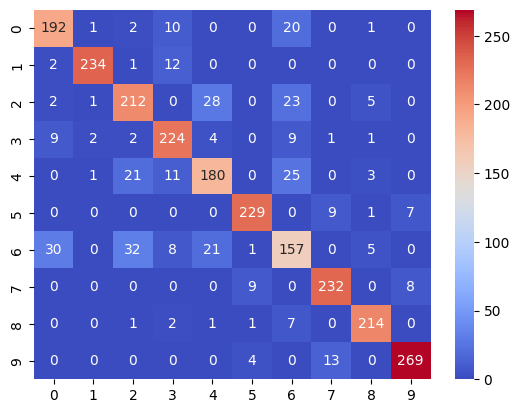

CPU times: total: 5min 42s
Wall time: 1min 30s


In [60]:
import joblib, xgboost as xgb
from dask.distributed import Client, LocalCluster 

def test():
    cluster = LocalCluster()  
    client = Client(cluster)  
    
    xgb_scaler = StandardScaler().fit(x_train_full)
    xgb_x_test = xgb_scaler.transform(x_test)
    xgb_pca = PCA(n_components).fit(x_train_full)
    xgb_x_test = xgb_pca.transform(x_test)

    preprocessing_steps = [('scaler', xgb_scaler), ('pca', xgb_pca)]
    estimator = ('classifier', xgb.XGBClassifier(n_jobs = 4, seed=42))
    model = Pipeline(steps=[*preprocessing_steps, estimator])
    
    with joblib.parallel_backend("dask", scatter=[x_train, y_train.ravel()]):  
        model.fit(x_train, y_train.ravel(), 
             classifier__eval_metric='mlogloss', 
#              classifier__early_stopping_rounds = 10, 
             classifier__eval_set = [(xgb_x_test, y_test.ravel())]) 
    y_pred = model.predict(x_test)

    results['xgb'] = [report(y_test.ravel(), y_pred)]
    _pipelines['xgb'] = model
    
    
%time test()

##  Comparsion

In [61]:
comparsion_df = pd.DataFrame(results)
comparsion_df.head()

,svc_rbf,svc_linear,lr,rf,xgb
0,0.866,0.8432,0.8428,0.848,0.8572


Report
              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80      1000
         1.0       0.99      0.96      0.98      1000
         2.0       0.81      0.78      0.80      1000
         3.0       0.84      0.91      0.87      1000
         4.0       0.81      0.81      0.81      1000
         5.0       0.95      0.91      0.93      1000
         6.0       0.69      0.62      0.65      1000
         7.0       0.90      0.91      0.90      1000
         8.0       0.93      0.96      0.94      1000
         9.0       0.92      0.93      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Accuracy 0.8619


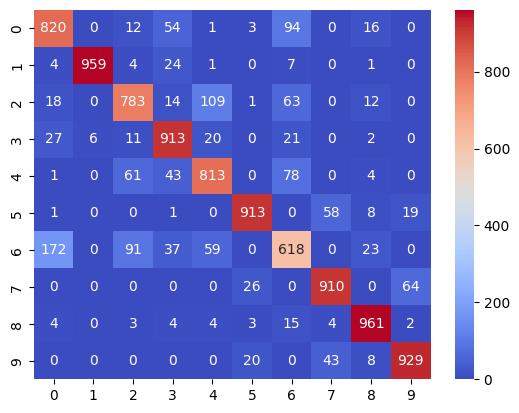

Report
              precision    recall  f1-score   support

         0.0       0.76      0.84      0.80      1000
         1.0       0.94      0.96      0.95      1000
         2.0       0.73      0.75      0.74      1000
         3.0       0.85      0.85      0.85      1000
         4.0       0.77      0.78      0.77      1000
         5.0       0.91      0.90      0.90      1000
         6.0       0.65      0.59      0.62      1000
         7.0       0.90      0.90      0.90      1000
         8.0       0.96      0.89      0.92      1000
         9.0       0.91      0.92      0.91      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Accuracy 0.8369


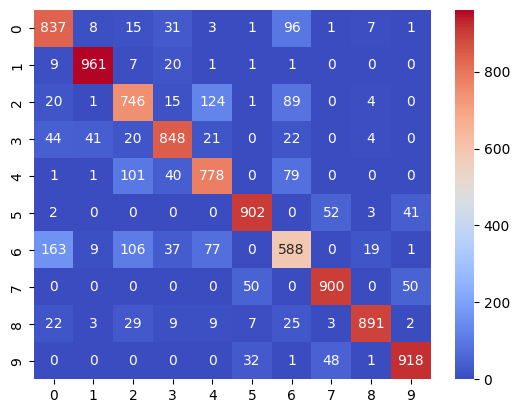

Report
              precision    recall  f1-score   support

         0.0       0.78      0.81      0.80      1000
         1.0       0.95      0.96      0.96      1000
         2.0       0.76      0.73      0.74      1000
         3.0       0.84      0.87      0.86      1000
         4.0       0.77      0.78      0.77      1000
         5.0       0.91      0.90      0.91      1000
         6.0       0.62      0.59      0.61      1000
         7.0       0.89      0.90      0.89      1000
         8.0       0.94      0.91      0.93      1000
         9.0       0.90      0.93      0.92      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Accuracy 0.8382


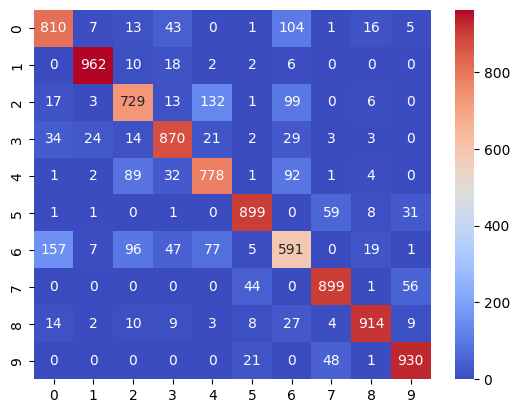

Report
              precision    recall  f1-score   support

         0.0       0.76      0.82      0.79      1000
         1.0       0.99      0.94      0.97      1000
         2.0       0.77      0.76      0.77      1000
         3.0       0.84      0.90      0.87      1000
         4.0       0.76      0.82      0.79      1000
         5.0       0.91      0.87      0.89      1000
         6.0       0.69      0.55      0.61      1000
         7.0       0.89      0.87      0.88      1000
         8.0       0.92      0.96      0.94      1000
         9.0       0.87      0.93      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Accuracy 0.8425


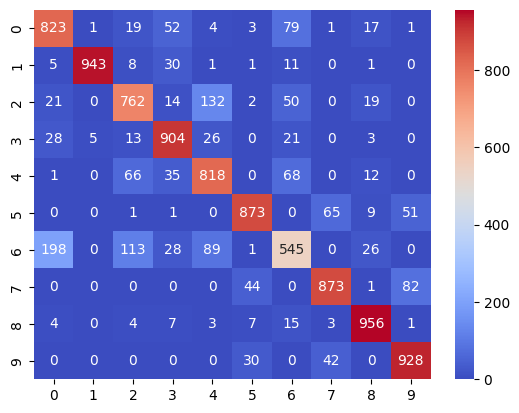

Report
              precision    recall  f1-score   support

         0.0       0.77      0.82      0.80      1000
         1.0       0.98      0.96      0.97      1000
         2.0       0.79      0.76      0.78      1000
         3.0       0.86      0.89      0.87      1000
         4.0       0.78      0.81      0.79      1000
         5.0       0.93      0.90      0.92      1000
         6.0       0.64      0.59      0.61      1000
         7.0       0.89      0.90      0.90      1000
         8.0       0.93      0.95      0.94      1000
         9.0       0.90      0.93      0.91      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Accuracy 0.8507


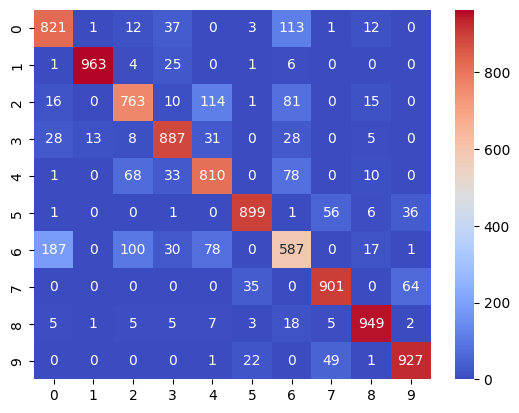

,svc_rbf,svc_linear,lr,rf,xgb
0,0.8619,0.8369,0.8382,0.8425,0.8507


In [62]:
# Results for test dataset

val_results = {key: [report(y_val.ravel(), _pipelines[key].predict(x_val))]  for key in _pipelines.keys()}
val_comparsion_df = pd.DataFrame(val_results)
val_comparsion_df.head()

(0.6, 0.95)

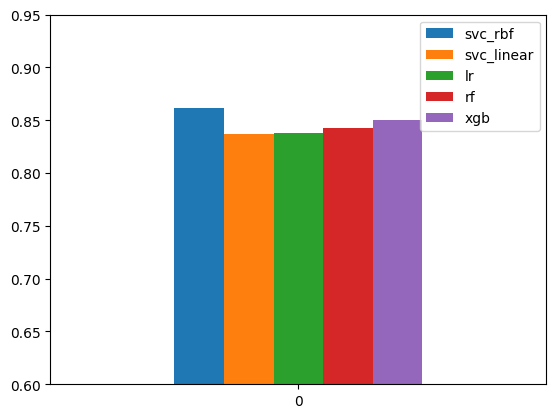

In [67]:
val_comparsion_df.plot.bar(rot=0)
plt.ylim(0.6, 0.95)

**Summary**

+ The best models is XGBoost and SVC with 'rbf' kernel: their accuracy results is too much close so we can define them all like "best"
+ All classifiers is bad in classifying 6th class "Shirt"

## Tuning

In [69]:
import os, joblib
from dask.distributed import Client, LocalCluster 

if 'cluster' not in locals(): 
    cluster = LocalCluster()  
    
if 'client' not in locals(): 
    client = Client(cluster)  

best_models = dict()

D:\conda\envs\tf_gpu2\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61119 instead
  warnings.warn(


*Notes:*

For RBF (Radial Basis Function) Kernel:

+ **C**: The regularization parameter controls the trade-off between maximizing the margin and minimizing the training error. Higher values of C lead to a smaller margin and potentially overfitting the data, while lower values allow for a larger margin but may lead to underfitting.

+ **kernel**: Specifies the type of kernel to use. In this case, 'linear' indicates the linear kernel, while 'rbf' indicates the RBF kernel.

+ **gamma**: This parameter is specific to the RBF kernel and represents the inverse of the standard deviation of the Gaussian function used in the kernel. It determines the influence of each training example, with smaller values indicating a broader influence and larger values indicating a narrower influence.

For  XGBoost:

+ **learning_rate**: The learning rate controls the contribution of each tree in the ensemble. Higher learning rates allow the model to learn faster but may lead to overfitting, while lower learning rates can improve generalization but require more boosting rounds.

+ **max_depth**: The maximum depth of a tree limits the number of nodes in each tree. Higher values can make the model more complex and prone to overfitting, while lower values can simplify the model but may lead to underfitting.

+ **n_estimators**: The number of trees (boosting rounds) in the ensemble. Increasing the number of trees can improve the model's performance but also increases computational complexity.

+ **subsample**: The subsample ratio of the training instances. It determines the fraction of samples used for training each tree. Values less than 1.0 introduce randomness and can help prevent overfitting.

+ **colsample_bytree**: The subsample ratio of columns when constructing each tree. It determines the fraction of features used for training each tree. Values less than 1.0 introduce randomness and can help prevent overfitting.

+ **reg_alpha** and **reg_lambda**: L1 and L2 regularization terms on the weights. They control the amount of regularization applied to the model, helping to prevent overfitting.

XGBoost has more hyperparameters and requires more time for computation so for **SVC (RBF)** simple **GridSearchCV**'ll be used and for **XGBoost** **RandomSearchCV**'ll be used.

Fitting 3 folds for each of 16 candidates, totalling 48 fits
CPU times: total: 2min 28s
Wall time: 12min 17s
Report
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86       226
         1.0       0.98      0.95      0.97       249
         2.0       0.83      0.80      0.81       271
         3.0       0.85      0.92      0.88       252
         4.0       0.82      0.76      0.79       241
         5.0       0.95      0.95      0.95       246
         6.0       0.71      0.70      0.70       254
         7.0       0.93      0.95      0.94       249
         8.0       0.96      0.97      0.97       226
         9.0       0.96      0.95      0.96       286

    accuracy                           0.88      2500
   macro avg       0.88      0.88      0.88      2500
weighted avg       0.88      0.88      0.88      2500

Accuracy 0.8832


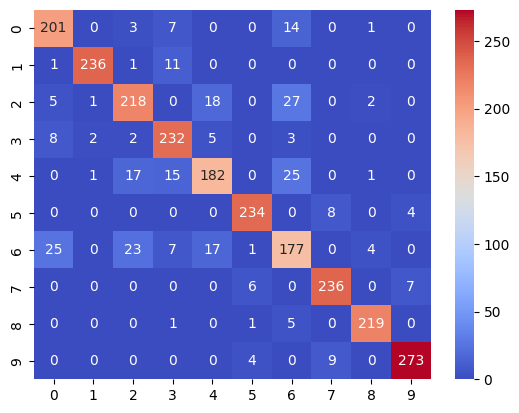

{'classifier__C': 10, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}


In [74]:
import os, joblib
from joblib import dump, load
from dask.distributed import Client, LocalCluster 
from sklearn.model_selection import GridSearchCV, KFold

try:
    best_models['SVM'] = load('svm_rbf_best02.joblib')
    report(y_test.ravel(), best_models['SVM'].predict(x_test))
except FileNotFoundError:
    estimator = ('classifier', SVC(probability=True) )
    param_grid = {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__gamma': [0.1, 0.01, 0.001, 0.0001],
        'classifier__kernel': ['rbf']
    }

    model = Pipeline(steps=[*preprocessing_steps, estimator])
    grid = GridSearchCV(model, param_grid, cv=KFold(3), n_jobs=-1, verbose=4)

    with joblib.parallel_backend("dask", scatter=[x_train, y_train.ravel()]):  
        %time grid.fit(x_train, y_train.ravel()) 

    best_model = grid.best_estimator_
    best_params = grid.best_params_

    y_pred = best_model.predict(x_test)

    report(y_test.ravel(), y_pred)
    print(best_params)
    
    best_models['SVM'] = best_model
    dump(best_model, 'svm_rbf_best02.joblib')

In [ ]:
import joblib
from joblib import dump, load
from dask.distributed import Client, LocalCluster 
from sklearn.model_selection import RandomizedSearchCV, KFold

try:
    best_models['XGB'] = load('xgb_best01.joblib')
    report(y_test.ravel(), best_models['XGB'].predict(x_test))
except FileNotFoundError:
    xgb_scaler = StandardScaler().fit(x_train_full)
    xgb_x_test = xgb_scaler.transform(x_test)
    xgb_pca = PCA(n_components).fit(x_train_full)
    xgb_x_test = xgb_pca.transform(x_test)
    
    preprocessing_steps = [('scaler', xgb_scaler), ('pca', xgb_pca)]
    estimator = ('classifier', xgb.XGBClassifier(n_jobs = -1, seed=42))
    param_grid = {
        "classifier__max_depth": [3, 4, 5, 7],
        "classifier__learning_rate": [0.1, 0.01, 0.05],
        "classifier__gamma": [0, 0.25, 1],
        "classifier__reg_lambda": [0, 1, 10],
        "classifier__scale_pos_weight": [1, 3, 5],
        "classifier__subsample": [0.8],
        "classifier__colsample_bytree": [0.5],
    }
#     param_grid = {
#         'classifier__n_estimators': [100, 200, 500],
#         'classifier__learning_rate': [0.001,0.01,0.1],
#         'classifier__booster': ['gbtree', 'gblinear'],
#         'classifier__gamma': [0, 0.5, 1],
#         'classifier__reg_alpha': [0, 0.5, 1],
#         'classifier__reg_lambda': [0.5, 1, 5],
#         'classifier__base_score': [0.2, 0.5, 1]
#     }
    
#         'classifier__min_child_weight': [1, 5, 10, 50, 100],
#         'classifier__learning_rate': [0.1, 0.01, 0.001],              # Learning rate
#         'classifier__max_depth': [3, 5, 7, 10],                           # Maximum depth of a tree
#         'classifier__n_estimators': [200, 300, 500],                  # Number of trees (boosting rounds)
#         'classifier__reg_alpha': [0, 0.1, 0.5, 1, 10, 20],                        # L1 regularization term on weights
#         'classifier__reg_lambda': [0, 0.1, 0.5, 1, 10, 20]                        # L2 regularization term on weights
#     }

    model = Pipeline(steps=[*preprocessing_steps, estimator])
    grid = GridSearchCV(model, param_grid, cv=KFold(3), n_jobs=-1, verbose=4, scoring="roc_auc")

    with joblib.parallel_backend("dask", scatter=[x_train, y_train.ravel()]):  
        grid.fit(x_train, y_train.ravel(), 
        classifier__eval_metric='mlogloss', 
        classifier__eval_set = [(xgb_x_test, y_test.ravel())]) 

    best_model = grid.best_estimator_
    best_params = grid.best_params_

    y_pred = best_model.predict(x_test)

    report(y_test.ravel(), y_pred)
    print(best_params)

    best_models['XGB'] = best_model
    dump(best_model, 'xgb_best01.joblib')

Fitting 3 folds for each of 324 candidates, totalling 972 fits


Pipeline(steps=[('normalizer', StandardScaler()),
                ('pca', PCA(n_components=118)),
                ('classifier', SVC(C=10, gamma=0.001, probability=True))])
Report
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       226
           1       0.99      0.95      0.97       249
           2       0.82      0.81      0.81       271
           3       0.86      0.92      0.89       252
           4       0.81      0.75      0.78       241
           5       0.95      0.94      0.95       246
           6       0.69      0.68      0.69       254
           7       0.92      0.95      0.94       249
           8       0.96      0.97      0.96       226
           9       0.96      0.95      0.95       286

    accuracy                           0.88      2500
   macro avg       0.88      0.88      0.88      2500
weighted avg       0.88      0.88      0.88      2500

Accuracy 0.8796


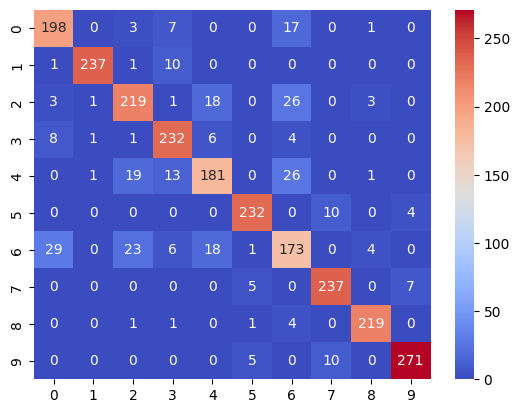

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=118)),
                ('classifier',
                 XGBClassifier(base_score=1, booster='gbtree', callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constr

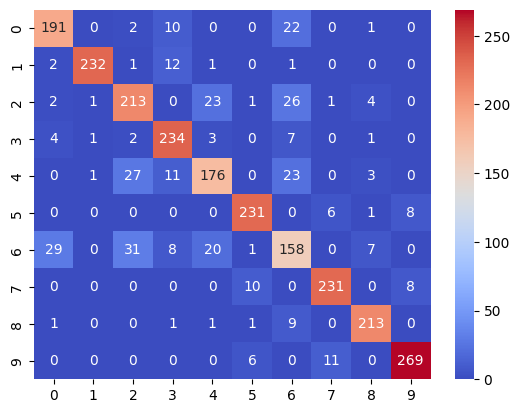

0.8592

In [22]:
#from dump
from joblib import dump, load

best_models['SVM'] = load('svm_rbf_best01.joblib')
print(best_models['SVM'])
report(y_test.ravel(), best_models['SVM'].predict(x_test))

best_models['XGB'] = load('xgb_best00.joblib')
print(best_models['XGB'])
report(y_test.ravel(), best_models['XGB'].predict(x_test))

# Model selection

In [23]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

votes = [
    ('svc', best_models['SVM']),
    ('xgb', best_models['XGB']),
]

with joblib.parallel_backend("dask", scatter=[x_train, y_train.flatten()]): 
    vclassifier = VotingClassifier(estimators=votes, voting='hard', n_jobs=4)
    %time vclassifier.fit(x_train, y_train.flatten())    

CPU times: total: 44.9 s
Wall time: 10min 34s


In [25]:
vclassifier_ = cross_validate(vclassifier, x_train, y_train.flatten(), cv=KFold(3))
vclassifier_

{'fit_time': array([379.03999496, 382.49198031, 402.65600061]),
 'score_time': array([9.40300536, 2.59099889, 9.34899855]),
 'test_score': array([0.84973005, 0.84248425, 0.8559856 ])}

In [ ]:
vclassifier.fit(x_train_full, y_train_full.flatten())

VotingClassifier(estimators=[('svc',
                              Pipeline(steps=[('normalizer', StandardScaler()),
                                              ('pca', PCA(n_components=118)),
                                              ('classifier',
                                               SVC(C=10, gamma=0.001,
                                                   probability=True))])),
                             ('xgb',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('pca', PCA(n_components=118)),
                                              ('classifier',
                                               XGBClassifier(base_score=1,
                                                             booster='gbtree',
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                

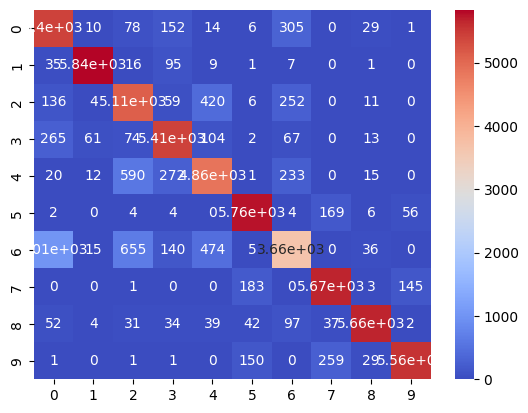

-----Train perfomance----
Report
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      1000
           1       0.98      0.97      0.97      1000
           2       0.77      0.84      0.80      1000
           3       0.87      0.89      0.88      1000
           4       0.82      0.81      0.81      1000
           5       0.93      0.94      0.93      1000
           6       0.74      0.55      0.63      1000
           7       0.90      0.93      0.91      1000
           8       0.97      0.94      0.95      1000
           9       0.94      0.92      0.93      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.86     10000
weighted avg       0.87      0.87      0.86     10000

Accuracy 0.8653


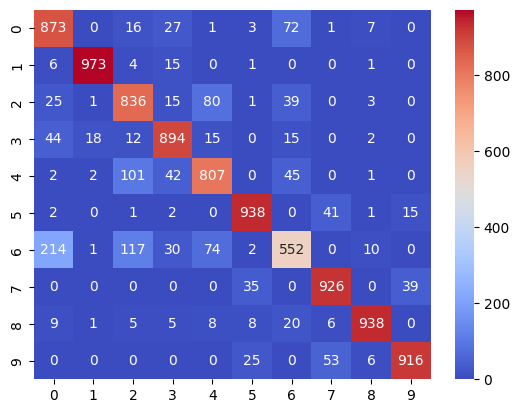

0.8653

In [24]:
print(vclassifier)
y_pred_train = vclassifier.predict(x_train_full)
y_pred_test = vclassifier.predict(x_val)

print('Test perfomance'.center(25, '-'))
report(y_train_full, y_pred_train)

print('Train perfomance'.center(25, '-'))
report(y_val, y_pred_test)


## Summary

+ Data Exploratory Analysis for the Fashion-MNIST dataset is performed. The distributions are demonstrated separately for each class and Fast Fourier Transform for 3 examples from each class.
+ Performed Principal Components Analysis and selected the number of n_components in accordance with the .85 quantile of explained variance

Fashion-MNIST is expensive dataset and the next results is recieved for 10, 000 training samples and 2, 500 test samples:
+ Hypeparameter tuning was applied to the selected models. We selected SearchGrid and RandomizedGrid for SVM with RBF kernel and XGBClassifier, respectively.

For SVM with RBF kernel:
```Python
{'classifier__C': 10, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}
```

For XGBboost:
```Python
{'classifier__reg_lambda': 0.5, 'classifier__reg_alpha': 1, 'classifier__n_estimators': 200, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0, 'classifier__booster': 'gbtree', 'classifier__base_score': 1}
```

+ Final model was choosed by VotingClassifier
+ SVM with RBF kernel showed the best Accuracy (88%), which is significantly lower than the state-of-the-art results using CNN. 

*Note:* The hypertuned SVM with RBF kernel could show better results than the "hypertuned" XGBoost Classifier because it was trained with RandomizedSearch. [Some results](https://www.kaggle.com/code/gauravduttakiit/fashion-mnist-classifier-lazy-predict) show the opposite: XGBClassifier should be better than SVM with RBF kernel, but I am not able to verify this evidence because the time to compute the full parameter grid is very long. 

+ In general, we can see that classical machine learning methods show significantly worse results than Neural Networks, so CNN-based models remain the best architecture for solving Fashion-MNIST. 